In [3]:
!pip install scikit-plot

In [0]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc_curve

In [0]:
import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)

save_file('https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_train.csv', 'seattle_rain_train.csv')
save_file('https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_test.csv', 'seattle_rain_test.csv')

<div class="alert alert-block alert-success">
<p>Read in the data</p>
</div>

In [6]:
rain = pd.read_csv('seattle_rain_train.csv')
print(rain.head())
rain.shape

         DATE  PRCP  TMAX  TMIN  ...  YEST_PRCP  SUM7_PRCP  SUM14_PRCP  SUM30_PRCP
0  1948-01-30  0.03    47    30  ...       0.22       0.35        0.56        4.28
1  1948-01-31  0.21    35    27  ...       0.03       0.46        0.77        4.02
2  1948-02-01  0.03    39    30  ...       0.21       0.49        0.80        3.46
3  1948-02-02  0.00    43    26  ...       0.03       0.49        0.80        3.04
4  1948-02-03  0.20    38    26  ...       0.00       0.69        1.00        2.93

[5 rows x 16 columns]


(18964, 16)

<div class="alert alert-block alert-success">
<p>Choose relevent features (Ignore ID, Date, and TMRW_PRCP)</p>
</div>

In [0]:
target = 'TMRW_RAIN'
features = ['PRCP', 'TMAX', 'TMIN', 'RAIN', 'TMIDR', 'TRANGE', 'MONTH', 'SEASON', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']

<div class="alert alert-block alert-success">
<p>Split into train and validation set</p>
</div>

In [0]:
train_data, validation_data = train_test_split(rain, test_size=0.2)
test_data = pd.read_csv('seattle_rain_train.csv')

<div class="alert alert-block alert-success">
<p>See what the majority class is and that we can see what we should be more accurate than.</p>
</div>

In [10]:
len(rain[rain['TMRW_RAIN'] == 1]) / len(rain)

0.42491035646488085

<div class="alert alert-block alert-success">
<p>The majority in TMRW_RAIN was 0, appearing 58% of the time. We should be more accurate than that.</p>
</div>

<div class="alert alert-block alert-success">
<h1>Random Forest Classifier</h1>
<p>Starting with Random Forest Classifier. Use GridSearch to find best hyperparameters (takes a bit of time)</p>
</div>

In [13]:
max_depth = [1] + np.arange(5, 16, 5).tolist()
min_samples_leaf = [1] + np.arange(5, 21, 5).tolist()

hyperparameters = {'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

search = GridSearchCV(estimator=RandomForestClassifier(), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10}


<div class="alert alert-block alert-success">
<p>Make graphs for accuracy of train and validation data</p>
</div>

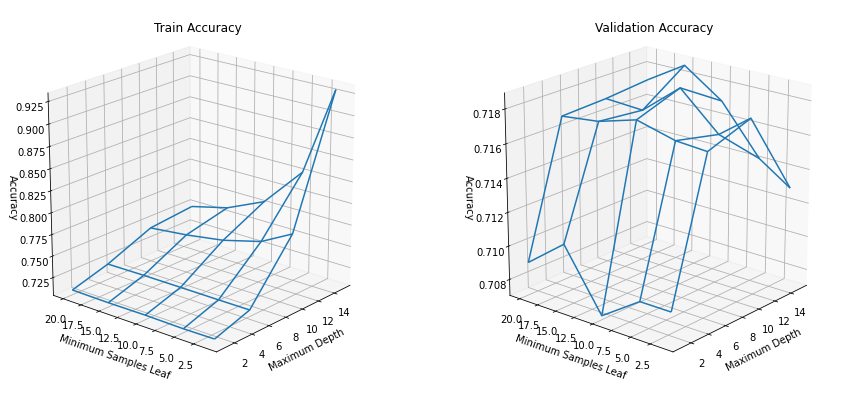

In [14]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

<div class="alert alert-block alert-success">
<p>Get accuracy score</p>
</div>

In [15]:
randomForest = RandomForestClassifier(max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'])
randomForest.fit(train_data[features], train_data[target])

predictions = randomForest.predict(validation_data[features])
print(accuracy_score(validation_data[target], predictions))

0.7271289216978645


<div class="alert alert-block alert-success">
<p>Get ROC Curve for Random Forest Classifier</p>
</div>

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


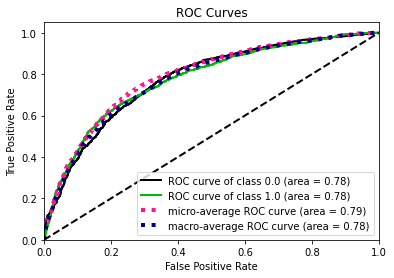

In [16]:
probabilities = randomForest.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>KNearestNeighbor</h1>
</div>

In [17]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 20)

best_knn = KNeighborsClassifier(n_neighbors=1)
best_error = 0

for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train_data[features], train_data[target])

    train_predictions = knn.predict(train_data[features])
    validation_predictions = knn.predict(validation_data[features])

    train_score = accuracy_score(train_data[target], train_predictions)
    validation_score = accuracy_score(validation_data[target], validation_predictions)

    if validation_score > best_error:
        best_error = validation_score
        best_knn = knn

    print("{0} neighbor(s): Training: {1} Validation: {2}".format(n, train_score, validation_score))

1 neighbor(s): Training: 0.9998022543009689 Validation: 0.614816767730029
2 neighbor(s): Training: 0.8043635884252851 Validation: 0.6414447666754548
3 neighbor(s): Training: 0.8030452837650781 Validation: 0.6540996572633799
4 neighbor(s): Training: 0.7634961439588689 Validation: 0.659372528341682
5 neighbor(s): Training: 0.762771076395755 Validation: 0.6688636962826259
6 neighbor(s): Training: 0.7410849647353503 Validation: 0.6635908252043238
7 neighbor(s): Training: 0.741414540900402 Validation: 0.669127339836541
8 neighbor(s): Training: 0.7300112055896117 Validation: 0.681518586870551
9 neighbor(s): Training: 0.7305385274536945 Validation: 0.6836277353018718
10 neighbor(s): Training: 0.722496869026432 Validation: 0.6831004481940417
11 neighbor(s): Training: 0.7236833432206183 Validation: 0.6817822304244662
12 neighbor(s): Training: 0.7190033616768835 Validation: 0.6875823886105985
13 neighbor(s): Training: 0.7193329378419353 Validation: 0.6873187450566833
14 neighbor(s): Training: 0.

<div class="alert alert-block alert-success">
<p>Not very accurate...</p>
</div>

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


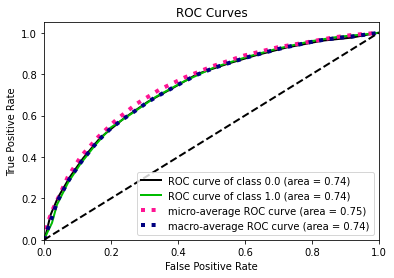

In [18]:
probabilities = best_knn.predict_proba(validation_data[features])

plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>Logistic Regression</h1>
</div>

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L1 Regression</h2>
</div>

In [0]:
hyperparameters = {'penalty': ['l1'], 'C': [1/1, 1/4, 1/10, 1/1e2, 1/1e3, 1/1e5]}

search = GridSearchCV(estimator=LogisticRegression(fit_intercept=False, solver='liblinear'), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'C': 1.0, 'penalty': 'l1'}


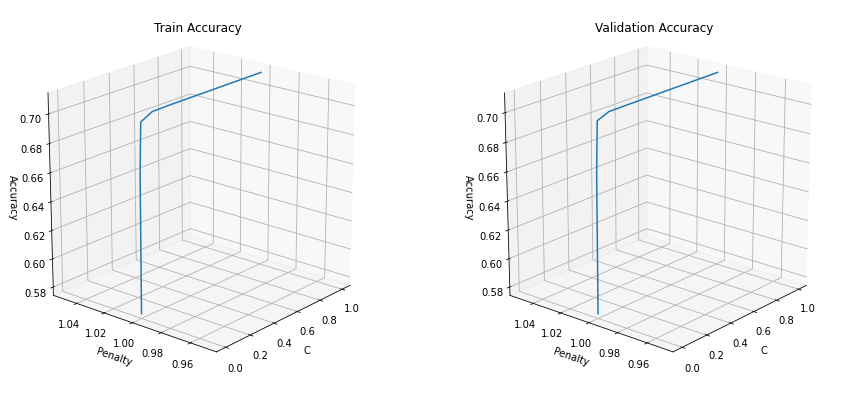

In [0]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['C']), len(hyperparameters['penalty'])))
    cs = cv_results['param_C'].reshape(scores.shape).data.astype(float)
    penalties = np.ma.asarray(np.array([1, 1, 1, 1, 1, 1])).reshape(scores.shape).data.astype(int)
    # penalties = cv_results['param_penalty'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(cs, penalties, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('C')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

In [0]:
l1_model = LogisticRegression(penalty='l1', C = 1/4, fit_intercept=False, solver='liblinear')
l1_model.fit(train_data[features], train_data[target])

predictions = l1_model.predict(validation_data[features])

weights = model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))

accuracy_score(validation_data[target], predictions)

NameError: ignored

In [0]:
probabilities = l1_model.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L2 Regression</h2>
</div>

In [14]:
l2_penalties = [1e-4,1e-3,1e-2,1e-1, 1, 4,10, 1e2, 1e3, 1e5, 1e6]

for l2_penalty in l2_penalties:
    model = LogisticRegression(penalty='l2', random_state=1, fit_intercept=False, C=1/l2_penalty, max_iter=300).fit(train_data[features], train_data[target])
    predicted_vals = model.predict(validation_data[features])
    model_accuracy = accuracy_score(validation_data[target], predicted_vals)
    print("Model accuracy at L2 = \t " + str(l2_penalty) + " is:\t ", model_accuracy)

Model accuracy at L2 = 	 0.0001 is:	  0.7049828631689955
Model accuracy at L2 = 	 0.001 is:	  0.7052465067229107
Model accuracy at L2 = 	 0.01 is:	  0.7052465067229107
Model accuracy at L2 = 	 0.1 is:	  0.7052465067229107
Model accuracy at L2 = 	 1 is:	  0.7055101502768257
Model accuracy at L2 = 	 4 is:	  0.706037437384656
Model accuracy at L2 = 	 10 is:	  0.706037437384656
Model accuracy at L2 = 	 100.0 is:	  0.7065647244924862
Model accuracy at L2 = 	 1000.0 is:	  0.6910097548114948
Model accuracy at L2 = 	 100000.0 is:	  0.656999736356446
Model accuracy at L2 = 	 1000000.0 is:	  0.5742156604271026


In [12]:
l2_model = LogisticRegression(penalty='l2', C = 1/4, fit_intercept=False, max_iter=500)
l2_model.fit(train_data[features], train_data[target])

predictions = l2_model.predict(validation_data[features])

weights = l2_model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))
print()
accuracyScore = accuracy_score(validation_data[target], predictions)
print("Accuracy Score at L2 = 4 is: ", accuracyScore)

feature: PRCP, weight: 1.1049303660702707
feature: TMAX, weight: -0.017358771733022287
feature: TMIN, weight: 0.010779034552612025
feature: RAIN, weight: 1.0028281302228077
feature: TMIDR, weight: -0.003289868590255837
feature: TRANGE, weight: -0.028137806285724553
feature: MONTH, weight: 0.00960654084447154
feature: SEASON, weight: -0.057418617183967145
feature: YEST_RAIN, weight: 0.16115154244435936
feature: YEST_PRCP, weight: -0.10742175516335417
feature: SUM7_PRCP, weight: 0.10280211074765314
feature: SUM14_PRCP, weight: -0.04171970942464692
feature: SUM30_PRCP, weight: 0.07932478694660226

Accuracy Score at L2 = 4 is:  0.706037437384656


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


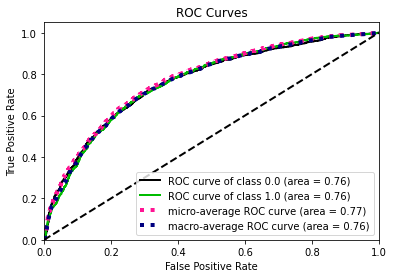

In [0]:
probabilities = l2_model.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

# Adaboost


In [25]:
adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=1)
adaboost_clf.fit(train_data[features], train_data[target])
adaboost_prediction = adaboost_clf.predict(validation_data[features])
adaboost_score = adaboost_clf.score(validation_data[features], validation_data[target])
print('Adaboost Model Accuracy = ' + str(adaboost_score))

Adaboost Model Accuracy = 0.7078829422620617


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


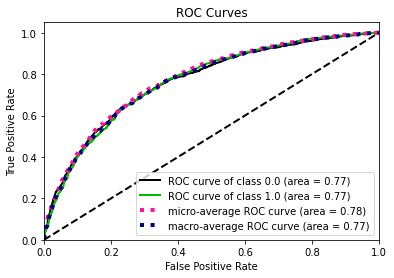

In [27]:
adaboost_prediction_prob = adaboost_clf.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], adaboost_prediction_prob)
plt.show()

<div class="alert alert-block alert-success">
<h1>Get Prediction for Test</h1>
</div>

In [0]:
rain_test = pd.read_csv('seattle_rain_test.csv')

predictions = randomForest.predict(rain_test[new_features])

In [0]:
rain_test['Category'] = predictions

In [0]:
submission = rain_test[['Category', 'Id']]

In [0]:
submission.to_csv('submission.csv', index=False)